## Final Features Model - XGBoost

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import datetime
import missingno as msno
import lightgbm as lgb
import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, TimeSeriesSplit, train_test_split,StratifiedKFold
import gc
from statistics import mean
import pickle
# Any results you write to the current directory are saved as output.

### Setup Cross Validation
1. Divide Train set in subsets (Training set itself + Local Test set)
2. Define Validation Metric (in our case it is ROC-AUC)
3. Stop training when Validation metric stops improving
4. Take average of each fold's prediction for the Local Test set.

In [ ]:
train_full = pd.read_pickle('data/train_feat.pkl')
test_full = pd.read_pickle('data/test_feat.pkl')

# Not using the below since the object type is all converted to category type already
# Label Encoding for categoricals
for f in test_full.columns:
    if train_full[f].dtype=='object' or test_full[f].dtype=='object': 
        train_full[f] = train_full[f].fillna('unseen_before_label')
        test_full[f]  = test_full[f].fillna('unseen_before_label')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_full[f].values) + list(test_full[f].values))
        train_full[f] = lbl.transform(list(train_full[f].values))
        test_full[f] = lbl.transform(list(test_full[f].values)) 

# Fill NA's for numerics
# train_full = train_full.fillna(-999)
# test_full = test_full.fillna(-999)

In [ ]:
with open('data/corr_feat.pkl', 'rb') as f:
    correlated_features = pickle.load(f)
    
rm_cols = [
    'TransactionID','TransactionDT', 
    'isFraud',
    'id_31'  # remove time dependent features - these cause model to overfit too much
#     'V300','V309','V111','V124','V106','V125','V315','V134','V102','V123','V316','V113',
#               'V136','V305','V110','V299','V289','V286','V318','V304','V116','V284','V293',
#               'V137','V295','V301','V104','V311','V115','V109','V119','V321','V114','V133','V122','V319',
#               'V105','V112','V118','V117','V121','V108','V135','V320','V303','V297','V120',
#               'V1','V14','V41','V65','V88', 'V89', 'V107', 'V68', 'V28', 'V27', 'V29', 'V241','V269',
#               'V240', 'V325', 'V138', 'V154', 'V153', 'V330', 'V142', 'V195', 'V302', 'V328', 'V327', 
#               'V198', 'V196', 'V155' # remove bunch of V features
] #+ correlated_features

# Final features
features_columns = [col for col in list(train_full.columns) if col not in rm_cols]

In [ ]:
X = train_full[features_columns]
y = train_full['isFraud']

# # Split holdout as 15% of the train set
# X, X_holdout, y, y_holdout = train_test_split(train_full[features_columns], train_full['isFraud'], 
#                                               test_size=0.15, random_state=42, shuffle=False)
# #                                               stratify = train_full['isFraud'])

del train_full
gc.collect()

In [ ]:
xgb_params=dict(booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=-999, n_estimators=800, 
              objective='binary:logistic', random_state=2019, eval_metric='auc',
              subsample=0.9, scale_pos_weight = 20)

In [ ]:
NFOLDS =5
# folds = StratifiedKFold(n_splits=NFOLDS,random_state=123,shuffle=False) # split by stratified folds. Do shuffle =F
folds = KFold(n_splits=NFOLDS,random_state=123,shuffle=False) # split by stratified folds
# folds = TimeSeriesSplit(n_splits=NFOLDS) # split by time - try timeseries split, perhaps less overfitting? result: worse overfitting

aucs = []
clfs=[]
pred_len = len(test_full)
prediction = np.zeros(pred_len)

for fold, (trn_idx, test_idx) in enumerate(folds.split(X,y)):
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = xgb.DMatrix(data=X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = xgb.DMatrix(data=X.iloc[test_idx], label=y.iloc[test_idx])
    clf = xgb.train(xgb_params, 
                    trn_data, 
                    evals=[(trn_data, 'train'), (val_data, 'valid')], 
                    early_stopping_rounds=100,
                    verbose_eval=20
                   )
    
    print('AUC for validation fold {}: {}'.format(fold+1, clf.best_score))
    aucs.append(clf.best_score)
    
#     holdout_pred = clf.predict(X_holdout)
#     print('AUC for holdout set - fold ', roc_auc_score(y_holdout, holdout_pred))
    
    prediction += clf.predict(xgb.DMatrix(test_full[features_columns]))

print("Cross Validation AUC: ", sum(aucs)/NFOLDS)
final_predictions = prediction/NFOLDS

- Xgboost Model, final features -> CV: ; LB:


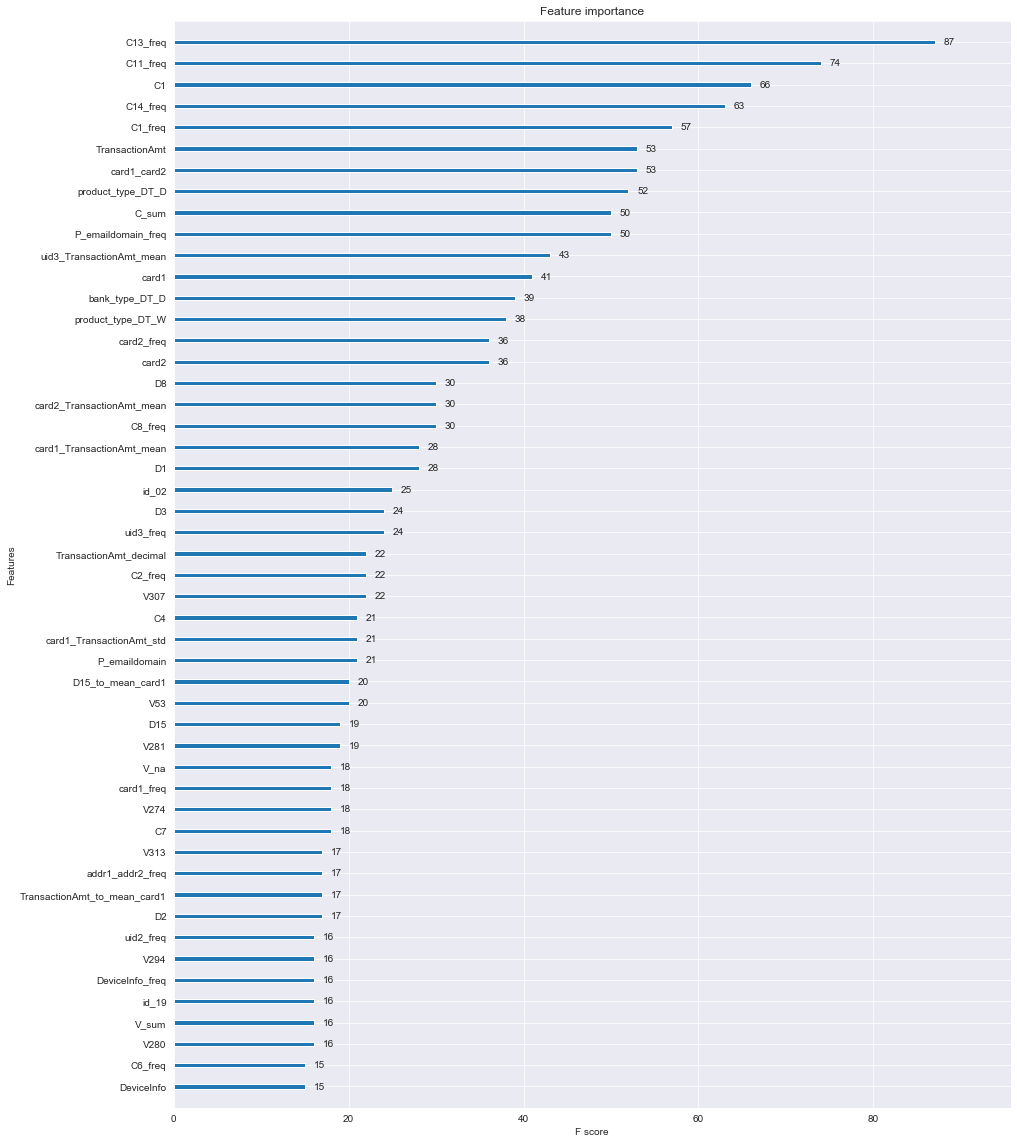

In [49]:
fig, ax = plt.subplots(figsize=(15, 20))
xgb.plot_importance(clf,max_num_features=50,ax=ax,)
# for i in range(NFOLDS):
#     fig, ax = plt.subplots(figsize=(15, 20))
#     xgb.plot_importance(clfs[i],max_num_features=50,ax=ax)

In [50]:
sample_submission = pd.read_csv('data/sample_submission.csv', index_col='TransactionID')
sample_submission['isFraud'] = prediction
sample_submission.to_csv('data/xgboost_finalfeat.csv')

In [24]:
X.shape

(590540, 227)